End-to-end (current focus: Readmission with XGBoost + Optuna). Structure prepared for mortality & prolonged LOS later.

In [ ]:
import os, shutil, datetime, glob
from pathlib import Path
# Robust project root detection early so relative paths don't create nested folders
NB_CWD = Path.cwd()
if NB_CWD.name == 'notebooks' and (NB_CWD.parent / 'data').exists():
    PROJECT_ROOT = NB_CWD.parent
else:
    PROJECT_ROOT = NB_CWD
DEPRECATED_DIR = PROJECT_ROOT / 'deprecated'
DEPRECATED_DIR.mkdir(exist_ok=True)
legacy_candidates = [
    'train.py','refit_xgb_best.py','xgb_optuna_fast.py','xgb_optuna_tune.py',
    'shap_explain.py','group_shap.py','feature_schema_diff.py','metrics_diff.py'
]
dry_run = True  # set False to actually move
moved = []
for fname in legacy_candidates:
    src = PROJECT_ROOT / fname
    if src.exists():
        dst = DEPRECATED_DIR / fname
        if not dry_run and not dst.exists():
            shutil.move(str(src), str(dst))
        moved.append((fname, 'WOULD_MOVE' if dry_run else 'MOVED'))
print("Legacy script review:")
for row in moved:
    print(row)
print("Dry-run =", dry_run)
print("CWD:", os.getcwd())
print("Detected PROJECT_ROOT:", PROJECT_ROOT)
print("data dir exists:", (PROJECT_ROOT / 'data').exists())
print("List data prefix (up to 20 entries):")
for p in list((PROJECT_ROOT / 'data').glob('*'))[:20]:
    print('  ', p)

Legacy script review:
Dry-run = True
CWD: c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\notebooks
project/data exists: False
List project/data prefix:


In [3]:
import sys, json, random, numpy as np, pandas as pd
import importlib, platform
SEED = 42
random.seed(SEED); np.random.seed(SEED)
VERSIONS = {
    'python': sys.version.split()[0],
    'platform': platform.platform(),
}
for pkg in ['xgboost','optuna','shap','sklearn','pandas','numpy']:
    try:
        m = importlib.import_module(pkg if pkg != 'sklearn' else 'sklearn')
        VERSIONS[pkg] = getattr(m,'__version__', 'unknown')
    except Exception as e:
        VERSIONS[pkg] = f'NOT_AVAILABLE ({e})'
print(json.dumps(VERSIONS, indent=2))

{
  "python": "3.13.3",
  "platform": "Windows-10-10.0.19045-SP0",
  "xgboost": "2.1.1",
  "optuna": "4.5.0",
  "shap": "0.48.0",
  "sklearn": "1.7.1",
  "pandas": "2.3.1",
  "numpy": "2.2.6"
}


In [8]:
import os
import pandas as pd
from pathlib import Path
import random

NB_CWD = Path.cwd()
# Determine project root (one level up from notebooks directory)
if (NB_CWD / 'data').exists():
    # Notebook was launched from project root unexpectedly
    PROJECT_ROOT = NB_CWD
elif (NB_CWD / 'project').exists() and (NB_CWD.name == 'notebooks'):
    PROJECT_ROOT = NB_CWD.parent  # .../project
else:
    # Fallback heuristic
    PROJECT_ROOT = NB_CWD.parent
print(f"Detected project root: {PROJECT_ROOT}")

DATA_DIR = PROJECT_ROOT / 'data'
RUNS_ROOT = PROJECT_ROOT / 'runs'

# Candidate locations for labels (priority order)
LABEL_CANDIDATES = [
    DATA_DIR / 'labels.csv',          # canonical location
    PROJECT_ROOT / 'labels.csv',      # legacy root
]
labels_path = None
for cand in LABEL_CANDIDATES:
    if cand.exists():
        labels_path = cand
        break

# Fallback: latest run labels.csv
if labels_path is None:
    candidates = []
    if RUNS_ROOT.exists():
        for p in RUNS_ROOT.glob('*/data/labels.csv'):
            try:
                candidates.append((p.stat().st_mtime, p))
            except FileNotFoundError:
                pass
    if candidates:
        candidates.sort(reverse=True)
        labels_path = candidates[0][1]
        print(f"Using latest run labels: {labels_path}")

labels_df = None
if labels_path is not None:
    LABELS_PATH = str(labels_path)
    labels_df = pd.read_csv(LABELS_PATH)
else:
    print("No existing labels.csv found; attempting dynamic build or synthetic fallback.")
    try:
        from google.cloud import bigquery as bq  # type: ignore
        from project.labels import build_and_save_labels  # type: ignore
        client = bq.Client()
        cohort_path = DATA_DIR / 'initial_cohort.csv'
        if not cohort_path.exists():
            raise FileNotFoundError('initial_cohort.csv missing for dynamic label build')
        subj_ids = pd.read_csv(cohort_path)['subject_id'].tolist()
        out_path = DATA_DIR / 'labels.csv'
        out_path.parent.mkdir(parents=True, exist_ok=True)
        labels_df = build_and_save_labels(client, subj_ids, str(out_path))
        LABELS_PATH = str(out_path)
        print(f"Dynamically built labels to {LABELS_PATH}")
    except Exception as e:
        print(f"Dynamic build unavailable ({e}); creating synthetic labels.")
    if labels_df is None:
        cohort_path = DATA_DIR / 'initial_cohort.csv'
        if not cohort_path.exists():
            raise FileNotFoundError('initial_cohort.csv missing; cannot create synthetic labels')
        subj = pd.read_csv(cohort_path)
        random.seed(42)
        synth = pd.Series([1 if random.random() < 0.043 else 0 for _ in range(len(subj))])
        labels_df = pd.DataFrame({
            'subject_id': subj['subject_id'],
            'hadm_id': -1,  # placeholder
            'mortality_label': 0,
            'prolonged_los_label': 0,
            'readmission_label': synth.values
        })
        LABELS_PATH = '<synthetic>'
        print('Generated synthetic labels with ~4.3% prevalence for pipeline execution.')

# Defensive normalization for readmission column
if 'readmission_label' not in labels_df.columns:
    lower_map = {c.lower(): c for c in labels_df.columns}
    for alias in ['readmission_label','readmission','readmit','readmit_30d','readmission_30d']:
        if alias in lower_map:
            orig = lower_map[alias]
            if orig != 'readmission_label':
                labels_df.rename(columns={orig:'readmission_label'}, inplace=True)
            break
    if 'readmission_label' not in labels_df.columns:
        raise ValueError(f"Could not identify readmission column; columns: {list(labels_df.columns)}")

assert 'subject_id' in labels_df.columns, 'subject_id missing in labels'
labels_df = labels_df.drop_duplicates('subject_id')
try:
    labels_df['readmission_label'] = labels_df['readmission_label'].astype(int)
except Exception:
    pass

prev = labels_df['readmission_label'].mean()
print(f"Loaded labels source: {LABELS_PATH}")
print('Shape:', labels_df.shape, 'Readmission prevalence:', round(prev,4))

Detected project root: c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project
Loaded labels source: c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\data\labels.csv
Shape: (28473, 5) Readmission prevalence: 0.0433


In [9]:
expected_cols = {'subject_id','readmission_label'}
missing = expected_cols - set(labels_df.columns)
assert not missing, f'Missing expected columns: {missing}'
assert labels_df['subject_id'].isna().sum() == 0, 'Null subject_id found'
print('Basic schema validation passed.')

Basic schema validation passed.


In [10]:
import numpy as np
prev = labels_df['readmission_label'].mean()
print(f'Readmission Prevalence: {prev:.4f}')
print(labels_df['readmission_label'].value_counts())

Readmission Prevalence: 0.0433
readmission_label
0    27241
1     1232
Name: count, dtype: int64


In [15]:
import pandas as pd, os
from pathlib import Path
import sys

NB_CWD = Path.cwd()
# Ensure project root is on sys.path for module imports
if (NB_CWD.name == 'notebooks') and (NB_CWD.parent / 'src').exists():
    sys.path.insert(0, str(NB_CWD.parent))

if (NB_CWD / 'artifacts').exists() and (NB_CWD / 'data').exists():
    PROJECT_ROOT = NB_CWD
elif (NB_CWD.name == 'notebooks') and (NB_CWD.parent / 'artifacts').exists():
    PROJECT_ROOT = NB_CWD.parent
else:
    PROJECT_ROOT = NB_CWD.parent

ARTIFACTS_DIR = PROJECT_ROOT / 'artifacts'
feature_path = ARTIFACTS_DIR / 'features_full.parquet'

regenerated = False
if feature_path.exists() and feature_path.stat().st_size < 1000:
    print(f"Detected potentially corrupted feature parquet (size {feature_path.stat().st_size} bytes); regenerating.")
    cache_dir = PROJECT_ROOT / 'data' / 'extracted_cache'
    try:
        from src.features import build_features, build_feature_provenance  # type: ignore
        def load_opt(name):
            p = cache_dir / name
            return pd.read_parquet(p) if p.exists() else None
        demo = load_opt('demographics.parquet')
        first_adm = load_opt('first_admissions.parquet')
        vitals = load_opt('vitals_48h.parquet')
        labs = load_opt('labs_48h.parquet')
        rx = load_opt('prescriptions_48h.parquet')
        proc = load_opt('procedures_48h.parquet')
        feats = build_features(first_adm, demo, vitals, labs, rx, proc)
        feats = feats.reindex(labels_df['subject_id']).fillna(0.0)
        feats.to_parquet(feature_path)
        prov = build_feature_provenance(feats)
        (ARTIFACTS_DIR / 'feature_provenance.json').write_text(__import__('json').dumps(prov, indent=2))
        (ARTIFACTS_DIR / 'feature_columns.json').write_text(__import__('json').dumps(list(feats.columns)))
        regenerated = True
        print(f"Regenerated features_full.parquet with shape {feats.shape}.")
    except Exception as e:
        print(f"Feature regeneration failed: {e}")

if not feature_path.exists():
    raise FileNotFoundError(f"features_full.parquet not found at {feature_path}. Ensure artifact generation ran.")

feature_df = pd.read_parquet(feature_path)
if 'subject_id' in feature_df.columns:
    feature_df = feature_df.set_index('subject_id')
feature_df = feature_df.reindex(labels_df['subject_id']).fillna(0.0)
print('Feature matrix loaded from:', feature_path, '| regenerated' if regenerated else '')
print('Feature matrix shape:', feature_df.shape)

Detected potentially corrupted feature parquet (size 4 bytes); regenerating.
Regenerated features_full.parquet with shape (28473, 1429).
Regenerated features_full.parquet with shape (28473, 1429).
Feature matrix loaded from: c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\features_full.parquet | regenerated
Feature matrix shape: (28473, 1429)
Feature matrix loaded from: c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\artifacts\features_full.parquet | regenerated
Feature matrix shape: (28473, 1429)


In [16]:
from sklearn.model_selection import train_test_split
readmit_y = labels_df['readmission_label'].astype(int).to_numpy()
subject_index = feature_df.index.to_numpy()
X = feature_df.values
X_tr, X_temp, y_tr, y_temp, sid_tr, sid_temp = train_test_split(
    X, readmit_y, subject_index, test_size=0.4, stratify=readmit_y, random_state=SEED)
X_val, X_te, y_val, y_te, sid_val, sid_te = train_test_split(
    X_temp, y_temp, sid_temp, test_size=0.5, stratify=y_temp, random_state=SEED)
print('Split shapes: train', X_tr.shape, 'valid', X_val.shape, 'test', X_te.shape)

Split shapes: train (17083, 1429) valid (5695, 1429) test (5695, 1429)


In [17]:
pos_rate = y_tr.mean(); scale_pos_weight = (1-pos_rate)/max(pos_rate,1e-6)
print(f'Positive rate train={pos_rate:.4f} -> scale_pos_weight approx {scale_pos_weight:.2f}')

Positive rate train=0.0433 -> scale_pos_weight approx 22.12


In [18]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix
import numpy as np
C_FP = 1.0; C_FN = 5.0
beta = 2.0

def metrics_at(proba, y, thr):
    pred = (proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, pred).ravel()
    cost = C_FP*fp + C_FN*fn
    f1 = f1_score(y, pred)
    prec = tp/(tp+fp+1e-9); rec = tp/(tp+fn+1e-9)
    fbeta = (1+beta**2)*prec*rec/(beta**2*prec+rec+1e-9)
    return dict(f1=f1, precision=prec, recall=rec, cost=cost, fbeta=fbeta)

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
baseline_pipe = Pipeline([
    ("imp", SimpleImputer(strategy='median')),
    ("sc", StandardScaler(with_mean=False)),
    ("lr", LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear'))
])
baseline_pipe.fit(X_tr, y_tr)
baseline_val_proba = baseline_pipe.predict_proba(X_val)[:,1]
baseline_auc = roc_auc_score(y_val, baseline_val_proba)
print('Baseline Logistic Validation AUC:', round(baseline_auc,4))

Baseline Logistic Validation AUC: 0.5811


In [20]:
import xgboost as xgb
D_tr = xgb.DMatrix(X_tr, label=y_tr)
D_val = xgb.DMatrix(X_val, label=y_val)
D_te = xgb.DMatrix(X_te, label=y_te)

In [21]:
import optuna, xgboost as xgb
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=SEED), pruner=MedianPruner())
print('Study created.')

[I 2025-09-13 14:56:41,743] A new study created in memory with name: no-name-0447a6a0-5519-4262-94a8-64cfaae18695


Study created.


In [22]:
# Documented inline in objective cell below.
pass

In [23]:
import numpy as np, xgboost as xgb
EARLY_STOP = 50
MAX_ROUNDS = 1200

def objective(trial: optuna.Trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'eta': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_child_weight': trial.suggest_float('min_child_weight', 1.0, 10.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 5.0, log=True),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'scale_pos_weight': scale_pos_weight,
    }
    rounds = trial.suggest_int('n_estimators', 300, MAX_ROUNDS)
    evals = [(D_tr,'train'), (D_val,'valid')]
    booster = xgb.train(params, D_tr, num_boost_round=rounds, evals=evals,
                        early_stopping_rounds=EARLY_STOP, verbose_eval=False)
    best_auc = booster.best_score
    trial.set_user_attr('best_iteration', booster.best_iteration)
    return float(best_auc)
print('Objective defined.')

Objective defined.


In [24]:
N_TRIALS = 15  # adjust upward for thorough search
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=False)
print('Best AUC:', study.best_value)
print('Best Params:', study.best_params)

[I 2025-09-13 14:56:54,539] Trial 0 finished with value: 0.6421719220959888 and parameters: {'learning_rate': 0.019906996673933378, 'max_depth': 8, 'min_child_weight': 7.587945476302646, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'lambda': 0.004207053950287938, 'alpha': 0.0016400214911202306, 'gamma': 4.330880728874676, 'n_estimators': 841}. Best is trial 0 with value: 0.6421719220959888.
[I 2025-09-13 14:56:56,292] Trial 1 finished with value: 0.6622487470794913 and parameters: {'learning_rate': 0.06813099824138592, 'max_depth': 3, 'min_child_weight': 9.72918866945795, 'subsample': 0.9162213204002109, 'colsample_bytree': 0.6061695553391381, 'lambda': 0.005337032762603957, 'alpha': 0.004768785415482609, 'gamma': 1.5212112147976886, 'n_estimators': 772}. Best is trial 1 with value: 0.6622487470794913.
[I 2025-09-13 14:56:56,292] Trial 1 finished with value: 0.6622487470794913 and parameters: {'learning_rate': 0.06813099824138592, 'max_depth': 3, 'min_child_

Best AUC: 0.671940302722241
Best Params: {'learning_rate': 0.02460208061014162, 'max_depth': 4, 'min_child_weight': 6.506676052501415, 'subsample': 0.569746930326021, 'colsample_bytree': 0.6460723242676091, 'lambda': 0.029204338471814112, 'alpha': 0.04863951003835899, 'gamma': 3.925879806965068, 'n_estimators': 479}


In [25]:
trials_df = study.trials_dataframe()
print('Trials:', trials_df.shape)
try:
    optuna.visualization.plot_optimization_history(study)
except Exception:
    pass

Trials: (15, 16)


In [26]:
import xgboost as xgb, numpy as np
X_tr_full = np.vstack([X_tr, X_val])
y_tr_full = np.concatenate([y_tr, y_val])
D_full = xgb.DMatrix(X_tr_full, label=y_tr_full)
params = study.best_params.copy()
# Map naming differences
params_fixed = {
    'objective':'binary:logistic','eval_metric':'auc','tree_method':'hist','eta':params['learning_rate'],
    'max_depth':params['max_depth'],'min_child_weight':params['min_child_weight'],'subsample':params['subsample'],
    'colsample_bytree':params['colsample_bytree'],'lambda':params['lambda'],'alpha':params['alpha'],
    'gamma':params['gamma'],'scale_pos_weight':scale_pos_weight,
}
final_rounds = study.best_params['n_estimators']
final_booster = xgb.train(params_fixed, D_full, num_boost_round=final_rounds, evals=[(D_full,'train')], verbose_eval=False)
print('Final booster trained.')

Final booster trained.


In [27]:
import numpy as np
proba_test = final_booster.predict(D_te)
ths = np.linspace(0.01,0.5,100)
best = None
for t in ths:
    m = metrics_at(proba_test, y_te, t)
    if (best is None) or (m['f1'] > best['f1']):
        best = {**m, 'threshold': t}
print('Best threshold (F1):', best)

Best threshold (F1): {'f1': 0.10853530031612224, 'precision': np.float64(0.06234866828083393), 'recall': np.float64(0.4186991869901679), 'cost': np.float64(2264.0), 'fbeta': np.float64(0.19537177512449677), 'threshold': np.float64(0.4703030303030303)}


In [28]:
# Manual isotonic calibration (avoids CalibratedClassifierCV API issues)
from xgboost import XGBClassifier
from sklearn.isotonic import IsotonicRegression
import numpy as np

base_params = {k:params_fixed[k] for k in ['max_depth','subsample','colsample_bytree']}
base_model = XGBClassifier(**base_params,
                           learning_rate=params['learning_rate'],
                           n_estimators=final_rounds,
                           min_child_weight=params['min_child_weight'],
                           reg_lambda=params['lambda'],
                           reg_alpha=params['alpha'],
                           gamma=params['gamma'],
                           objective='binary:logistic',
                           tree_method='hist',
                           scale_pos_weight=scale_pos_weight,
                           eval_metric='logloss',
                           verbosity=0)
# Fit on training only (validation reserved for calibration mapping)
base_model.fit(X_tr, y_tr)
val_proba_raw = base_model.predict_proba(X_val)[:,1]
iso = IsotonicRegression(out_of_bounds='clip')
iso.fit(val_proba_raw, y_val)
print('Isotonic calibration fitted on validation set.')

def predict_calibrated(X):
    return iso.transform(base_model.predict_proba(X)[:,1])

Isotonic calibration fitted on validation set.


In [29]:
from sklearn.metrics import brier_score_loss
import json
cal_proba_test = predict_calibrated(X_te)
auc = roc_auc_score(y_te, cal_proba_test)
pr = average_precision_score(y_te, cal_proba_test)
brier = brier_score_loss(y_te, cal_proba_test)
report = {
    'auc': float(auc),
    'pr_auc': float(pr),
    'brier': float(brier),
    'threshold_f1': float(best['threshold']),
    'f1_at_threshold': float(best['f1']),
    'precision_at_threshold': float(best['precision']),
    'recall_at_threshold': float(best['recall']),
    'cost_at_threshold': float(best['cost']),
}
print(json.dumps(report, indent=2))

{
  "auc": 0.5965766076269682,
  "pr_auc": 0.05461967161773474,
  "brier": 0.04165366901400125,
  "threshold_f1": 0.4703030303030303,
  "f1_at_threshold": 0.10853530031612224,
  "precision_at_threshold": 0.06234866828083393,
  "recall_at_threshold": 0.4186991869901679,
  "cost_at_threshold": 2264.0
}


In [30]:
import numpy as np
sample_idx = np.random.choice(X_tr_full.shape[0], size=min(400, X_tr_full.shape[0]), replace=False)
X_sample = X_tr_full[sample_idx]
try:
    import shap
    explainer = shap.TreeExplainer(final_booster)
    shap_val = explainer.shap_values(X_sample)
    mean_abs = np.abs(shap_val).mean(axis=0)
    top_order = np.argsort(-mean_abs)[:20]
    print('Top 20 SHAP feature indices:', top_order[:10], '...')
except Exception as e:
    print('SHAP skipped:', e)

Top 20 SHAP feature indices: [  25  170    6 1169 1161  625 1292 1302 1031  770] ...


In [36]:
# Save artifacts relative to PROJECT_ROOT (avoid creating nested project folder)
import os, json
from pathlib import Path
OUT_DIR = Path(PROJECT_ROOT) / 'final_artifacts'
OUT_DIR.mkdir(exist_ok=True)
final_booster.save_model(str(OUT_DIR / 'model_readmission.json'))
with open(OUT_DIR / 'metrics.json','w',encoding='utf-8') as f:
    json.dump(report, f, indent=2)
with open(OUT_DIR / 'threshold.txt','w') as f:
    f.write(str(best['threshold']))
print('Artifacts saved to', OUT_DIR)

Artifacts saved to c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\final_artifacts


In [37]:
# Append metrics to experiment registry at project root
from pathlib import Path
import csv, time, os
REG_PATH = Path(PROJECT_ROOT) / 'experiment_registry.csv'
row = {'ts': time.time(), **report}
write_header = not REG_PATH.exists()
with open(REG_PATH,'a',newline='') as f:
    w = csv.DictWriter(f, fieldnames=row.keys())
    if write_header: w.writeheader()
    w.writerow(row)
print('Logged run to registry at', REG_PATH)

Logged run to registry at c:\Users\Almog Luz\Documents\GitHub\mlhc-final-project\project\experiment_registry.csv


C:\Users\Almog Luz\AppData\Local\Temp\ipykernel_14468\512248869.py:4: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_val, feature_df.iloc[sample_idx, :], max_display=25, show=False)


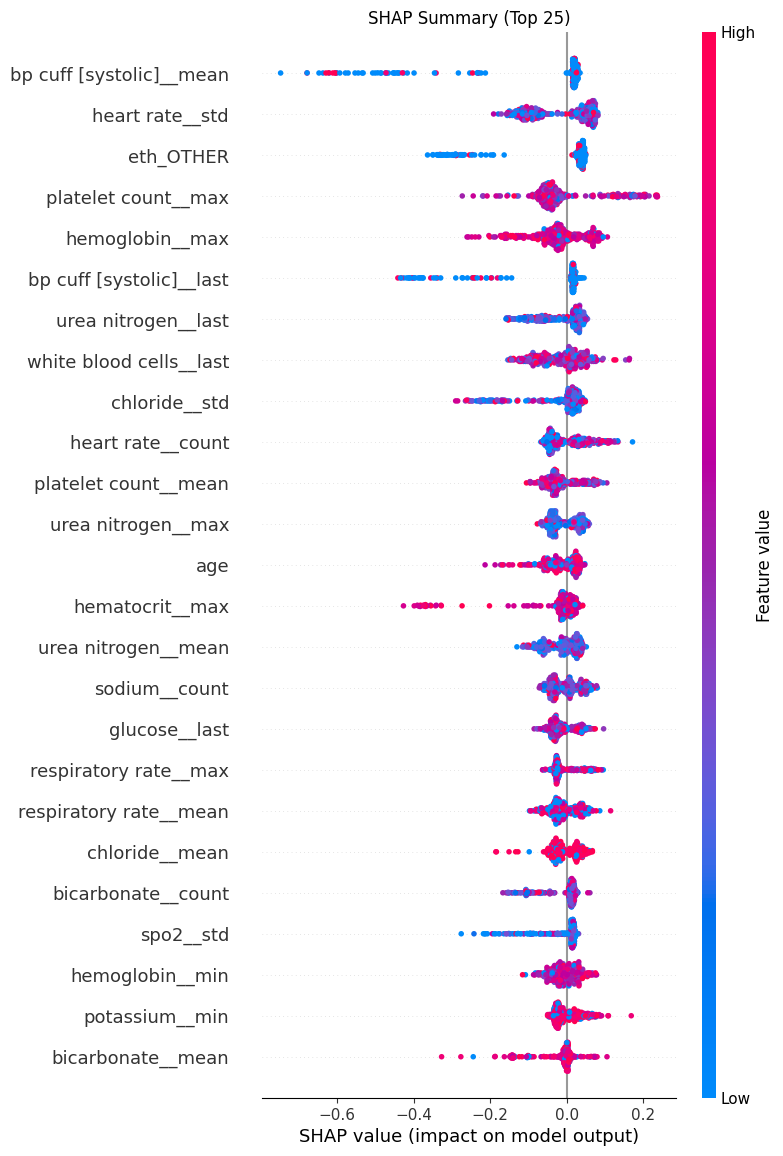

C:\Users\Almog Luz\AppData\Local\Temp\ipykernel_14468\512248869.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_val, feature_df.iloc[sample_idx, :], plot_type='bar', max_display=25, show=False)


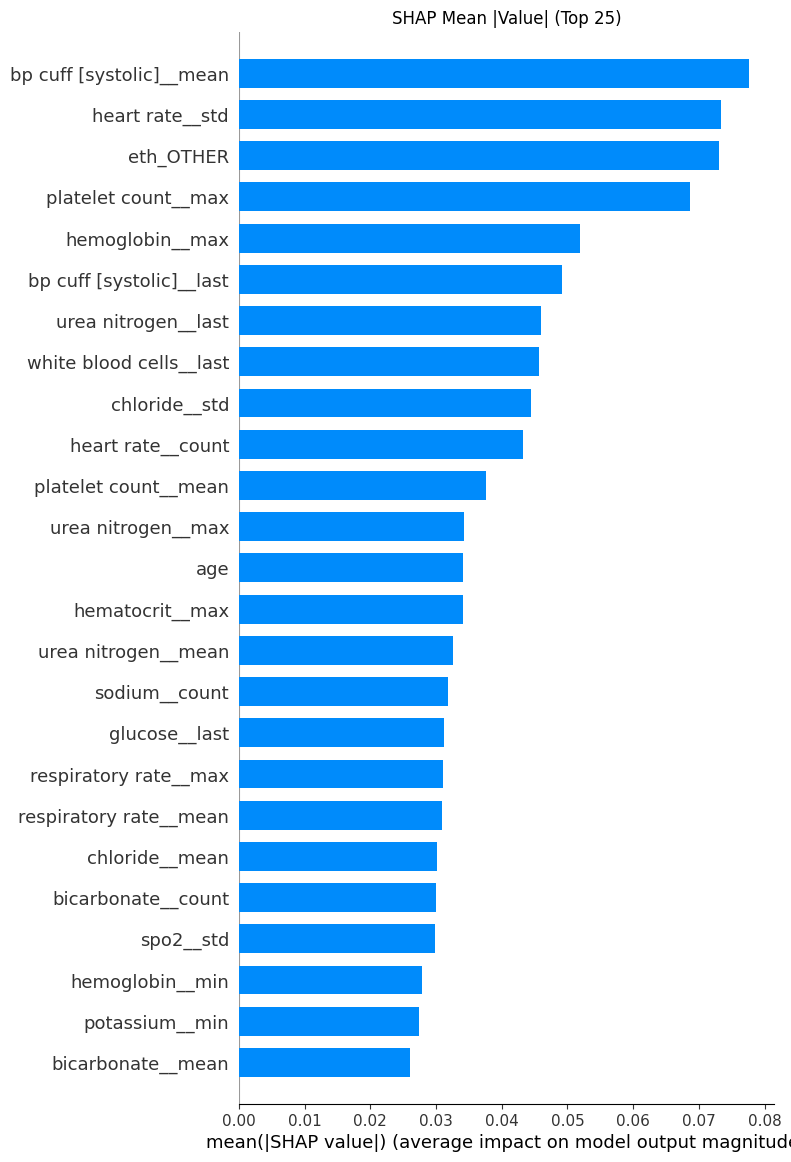

In [33]:
# SHAP visualization (summary dot + bar). Safe to rerun.
import shap, numpy as np, pandas as pd
import matplotlib.pyplot as plt
shap.summary_plot(shap_val, feature_df.iloc[sample_idx, :], max_display=25, show=False)
plt.title('SHAP Summary (Top 25)')
plt.show()
shap.summary_plot(shap_val, feature_df.iloc[sample_idx, :], plot_type='bar', max_display=25, show=False)
plt.title('SHAP Mean |Value| (Top 25)')
plt.show()

In [38]:
# Cleanup: remove unintended nested notebooks/project directory if artifacts duplicated
from pathlib import Path
import shutil
nested = Path.cwd() / 'project'
if nested.exists() and nested.is_dir():
    # Only remove if it contains only final_artifacts + experiment_registry.csv + deprecated (no exclusive data)
    allowed = {'final_artifacts','experiment_registry.csv','deprecated'}
    contents = {p.name for p in nested.iterdir()}
    extraneous = contents - allowed
    if not extraneous:
        print('Removing nested project folder to prevent duplication...')
        shutil.rmtree(nested)
    else:
        print('Nested project folder retained (unexpected contents):', extraneous)
else:
    print('No nested project folder detected.')

Removing nested project folder to prevent duplication...


In [34]:
# Bootstrap 95% CI for test AUC (fast, stratified)
import numpy as np
from sklearn.metrics import roc_auc_score
R = 1000  # increase to 5000 for tighter CI
rng = np.random.default_rng(42)
auc_samples = []
for _ in range(R):
    idx_pos = np.where(y_te==1)[0]
    idx_neg = np.where(y_te==0)[0]
    b_pos = rng.choice(idx_pos, size=len(idx_pos), replace=True)
    b_neg = rng.choice(idx_neg, size=len(idx_neg), replace=True)
    b_idx = np.concatenate([b_pos, b_neg])
    auc_samples.append(roc_auc_score(y_te[b_idx], cal_proba_test[b_idx]))
auc_samples = np.array(auc_samples)
ci_low, ci_high = np.percentile(auc_samples, [2.5, 97.5])
print(f"Test AUC bootstrap mean={auc_samples.mean():.4f} 95% CI=({ci_low:.4f},{ci_high:.4f}) n={R}")

Test AUC bootstrap mean=0.5965 95% CI=(0.5647,0.6285) n=1000


In [35]:
# 5-fold CV comparison (train+validation combined) for XGB (fixed best params) vs logistic baseline
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import xgboost as xgb

X_cv = np.vstack([X_tr, X_val])
y_cv = np.concatenate([y_tr, y_val])
print('CV dataset shape:', X_cv.shape)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
auc_xgb = []
auc_lr = []

# Use best params captured earlier (params_fixed)
params_cv = params_fixed.copy()
params_cv['eval_metric'] = 'auc'

for fold,(tr_idx, va_idx) in enumerate(skf.split(X_cv, y_cv), 1):
    Xtr, Xva = X_cv[tr_idx], X_cv[va_idx]
    ytr, yva = y_cv[tr_idx], y_cv[va_idx]
    # Logistic pipeline
    lr_pipe = Pipeline([
        ('imp', SimpleImputer(strategy='median')),
        ('sc', StandardScaler(with_mean=False)),
        ('lr', LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear'))
    ])
    lr_pipe.fit(Xtr, ytr)
    auc_lr.append(roc_auc_score(yva, lr_pipe.predict_proba(Xva)[:,1]))
    # XGB
    Dtr = xgb.DMatrix(Xtr, label=ytr)
    Dva = xgb.DMatrix(Xva, label=yva)
    booster = xgb.train(params_cv, Dtr, num_boost_round=params_cv.get('n_estimators', 500),
                        evals=[(Dva,'valid')], verbose_eval=False)
    proba_va = booster.predict(Dva)
    auc_xgb.append(roc_auc_score(yva, proba_va))
    print(f'Fold {fold}: AUC LR={auc_lr[-1]:.4f} XGB={auc_xgb[-1]:.4f}')

print('\nCV AUC Logistic: mean', f'{np.mean(auc_lr):.4f}', '±', f'{np.std(auc_lr):.4f}')
print('CV AUC XGB     : mean', f'{np.mean(auc_xgb):.4f}', '±', f'{np.std(auc_xgb):.4f}')

CV dataset shape: (22778, 1429)
Fold 1: AUC LR=0.6175 XGB=0.6176
Fold 2: AUC LR=0.6073 XGB=0.6475
Fold 3: AUC LR=0.5522 XGB=0.6249
Fold 4: AUC LR=0.5616 XGB=0.6057
Fold 5: AUC LR=0.5976 XGB=0.6122

CV AUC Logistic: mean 0.5872 ± 0.0257
CV AUC XGB     : mean 0.6216 ± 0.0144


In [ ]:
print('Utilities already modularized in train_core.py & explain.py; further refactor optional.')

In [ ]:
print('TODO: integrate pytest tests (feature shapes, leakage).')

In [ ]:
print('Future: single cli.py with commands: tune, train, evaluate, shap, predict.')

In [ ]:
print('Placeholders for LightGBM / CatBoost / TabNet to reuse feature_df and splits.')

In [ ]:
example_vec = X_te[0:1]
proba_one = calibrated.predict_proba(example_vec)[0,1]
print('Single prediction probability:', proba_one)

In [ ]:
OUT_DIR = PROJECT_ROOT / 'artifacts'
print(f"Artifacts directory set to {OUT_DIR}")

### Consolidated Artifacts
Artifacts now saved only to `project/artifacts` (previous `final_artifacts` removed during consolidation).